In [1]:
# For data management
import pandas as pd
import numpy as np

# Import classifiers
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# metrics contain our plot_confustion_matrix and classification_report
from sklearn import metrics

# Helper fuction to splitting data
from sklearn.model_selection import train_test_split

# For plotting
import matplotlib.pyplot as plt
%matplotlib inline 


# Image Classification

### Remember our main steps motto _isbe_.
1. i - Inspect and explore data.
2. s - Select and engineer features.
3. b - Build and train model.
4. e - Evaluate model.


# 1. Inspect and explore our data

In [2]:
df = pd.read_csv('data/digits-small.csv')
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Inspect for null values

In [3]:
df.isnull().sum()

label       0
pixel0      0
pixel1      0
pixel2      0
pixel3      0
           ..
pixel779    0
pixel780    0
pixel781    0
pixel782    0
pixel783    0
Length: 785, dtype: int64

In [4]:
df.isnull().sum().sum()

0

### Check for duplicates

In [5]:
# Check for duplicates
df.duplicated().sum()

0

### Lets look at our class balances

In [6]:
df.label.value_counts(), df.label.value_counts(normalize=True)

(1    440
 0    439
 7    437
 9    433
 2    425
 3    415
 6    410
 5    408
 4    398
 8    395
 Name: label, dtype: int64,
 1    0.104762
 0    0.104524
 7    0.104048
 9    0.103095
 2    0.101190
 3    0.098810
 6    0.097619
 5    0.097143
 4    0.094762
 8    0.094048
 Name: label, dtype: float64)

# Lets visualize one of the images...

In [7]:
df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### First, we need to create a list that is just our pixel columns

In [10]:
# This grabs all of the columns 
pixel_cols = df.columns

# This is currently a pandas index object
print(type(pixel_cols))

# Convert the pandas index object into a regular list
pixel_cols = list(pixel_cols)

# Sanity check that it is now just a list.
print(type(pixel_cols))

# Remove the label column from the list
# So all that remains are the pixel columns
# This happnes 'in place'
pixel_cols.remove('label')

#pixel_cols

<class 'pandas.core.indexes.base.Index'>
<class 'list'>


# Extract one row and reshape it to its original shape.

<class 'numpy.ndarray'>


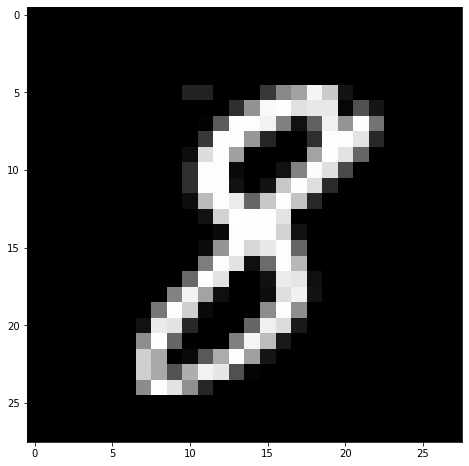

In [12]:
# Set the size of our plot
plt.figure(figsize=(8,8))


# Select just the pixel columns and convert them to a numpy array by using .values. 
imgs = df[pixel_cols].values

print(type(imgs))

# Select just one image from 
img = imgs[999]

# Reshape the image to be a 28x28 matrix (original format of image)
img = img.reshape(28,28)

# Plot reshaped image
plt.imshow(img, cmap='gray')

In [13]:
# Print the dimensions and type of the image
print(img.shape, type(img))

# Flatten the image using .flatten()
flat_image = img.flatten()

# Print the dimensions and type of the flat image
print(flat_image.shape, type(flat_image))

(28, 28) <class 'numpy.ndarray'>
(784,) <class 'numpy.ndarray'>


## What does the image look like if we dont reshape the image..?  
This is what the classifier will be 'seeing'.

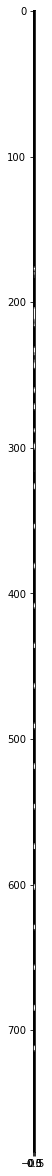

In [14]:
plt.figure(figsize=(8,21))

# Select just one image from 
img = imgs[9]

# Reshape the image to be a 784 by 1 
img = img.reshape(784,1)

# Plot reshaped image
plt.imshow(img, cmap='gray')

## Small detour on loading images.

<class 'PIL.JpegImagePlugin.JpegImageFile'>
<class 'numpy.ndarray'> (563, 1000)
<class 'numpy.ndarray'> (563000,)


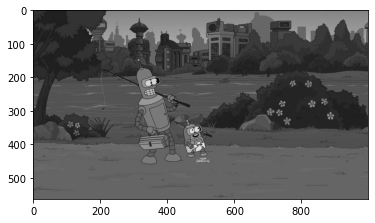

In [15]:
import PIL

# PIL is a library for handling images in python
image = PIL.Image.open('data/bender-and-baby.jpeg')
print(type(image))

# Plot the image using matplotlib
plt.imshow(image, cmap='gray')


# Convert the image to a numpy array of data. 
image_data = np.asarray(image).copy()

print(type(image_data), image_data.shape)


flat_image = image_data.flatten()
print(type(flat_image), flat_image.shape)

___
# 2. Select and engineer our features.
1. Create our `selected_features` that is the list of the columns we are going to use as our `X` data. 
2. Define our `X` and `y` data. 
2. Train-test-split our `X` and `y` data

### 1. Create our `selected_features` that is the list of the columns we are going to use as our `X` data. 

In [16]:
# IM DOING THIS AGAIN JUST FOR PRACTICE 

# This grabs all of the columns 
selected_features = df.columns

# This is currently a pandas index object
print(type(selected_features))

# Convert the pandas index object into a regular list
selected_features = list(selected_features)

# Sanity check that it is now just a list.
print(type(selected_features))

# Remove the label column from the list
# So all that remains are the pixel columns
# This happnes 'in place'
selected_features.remove('label')

# selected_features

<class 'pandas.core.indexes.base.Index'>
<class 'list'>


### 2. Define our `X` and `y`

In [17]:
X = df[selected_features]

y = df['label']

In [18]:
# Sanity checking the size of our dataframe / class balances. 
print(df.shape)
df.label.value_counts()

(4200, 785)


1    440
0    439
7    437
9    433
2    425
3    415
6    410
5    408
4    398
8    395
Name: label, dtype: int64

### 3. Train-test-split our `X` and `y` data

In [19]:
# 3. Train-test-split our `X` and `y` data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25)

____
# 3. Build and train our model
1. Initalize an empty model.
2. Fit that model. 

In [20]:
from sklearn import svm

# Initalize our Support Vector Classifier
model = svm.SVC()

In [21]:
model.fit(X_train, y_train)

SVC()

___
# 4. Evaluate our model
1. Get a baseline accuracy score.
2. Make new predictions using our test data. 
3. Print the classification report. 
4. Plot the confusion matrix of our predicted results. 

### 1. Make new predictions using our test data. 

In [22]:
accuracy = model.score(X_test, y_test)
print("Accuracy %f" % accuracy)

Accuracy 0.940000


In [24]:
# This will not work.
model.predict_proba(X_test)

AttributeError: predict_proba is not available when  probability=False

### 2. Make new predictions using our test data. 

In [25]:
y_pred = model.predict(X_test)

### 3. Print the classification report. 

In [22]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       119
           1       0.97      0.97      0.97       108
           2       0.96      0.96      0.96       113
           3       0.94      0.93      0.93        99
           4       0.93      0.94      0.94       100
           5       0.93      0.95      0.94       102
           6       0.95      1.00      0.97       110
           7       0.98      0.93      0.95        98
           8       0.93      0.89      0.91        85
           9       0.91      0.91      0.91       116

    accuracy                           0.95      1050
   macro avg       0.95      0.95      0.95      1050
weighted avg       0.95      0.95      0.95      1050



### 4. Plot the confusion matrix of our predicted results. 

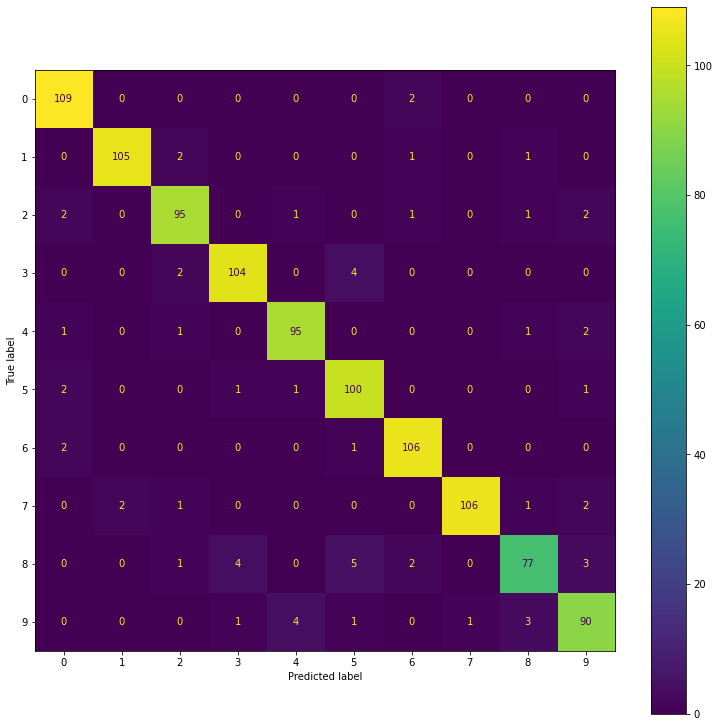

In [26]:
fig, ax = plt.subplots(figsize=(13,13))
metrics.plot_confusion_matrix(estimator=model, 
                              X=X_test, 
                              y_true=y_test, 
                              ax=ax)

In [27]:
# Lets build a function in which we can easily do all of this for any new model. 

def build_and_eval_model(model, X, y, random_state=23):
    print("Running report for model", model)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=random_state)    
    
    # Fit our model.
    model.fit(X_train, y_train)
    
    # Get the accuracy
    accuracy = model.score(X_test, y_test)
    print("\n\nAccuracy %f" % accuracy)
    
    
    # Make new predictions
    y_pred = model.predict(X_test)
    
    
    # Print the classification report. 
    print(metrics.classification_report(y_test, y_pred))
    
        
    # Plot the confusion matrix
    fig, ax = plt.subplots(figsize=(13,13))
    
    metrics.plot_confusion_matrix(estimator=model, 
                                  X=X_test, 
                                  y_true=y_test, 
                                  ax=ax)

    # Return the fitted model. 
    return model

Running report for model LogisticRegression()


Accuracy 0.871429
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       115
           1       0.95      0.95      0.95       123
           2       0.82      0.79      0.80       103
           3       0.83      0.77      0.80       100
           4       0.88      0.90      0.89        98
           5       0.80      0.84      0.82       102
           6       0.94      0.90      0.92       114
           7       0.91      0.92      0.92       103
           8       0.79      0.80      0.80        85
           9       0.86      0.84      0.85       107

    accuracy                           0.87      1050
   macro avg       0.87      0.87      0.87      1050
weighted avg       0.87      0.87      0.87      1050



/Users/zacharydesario/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

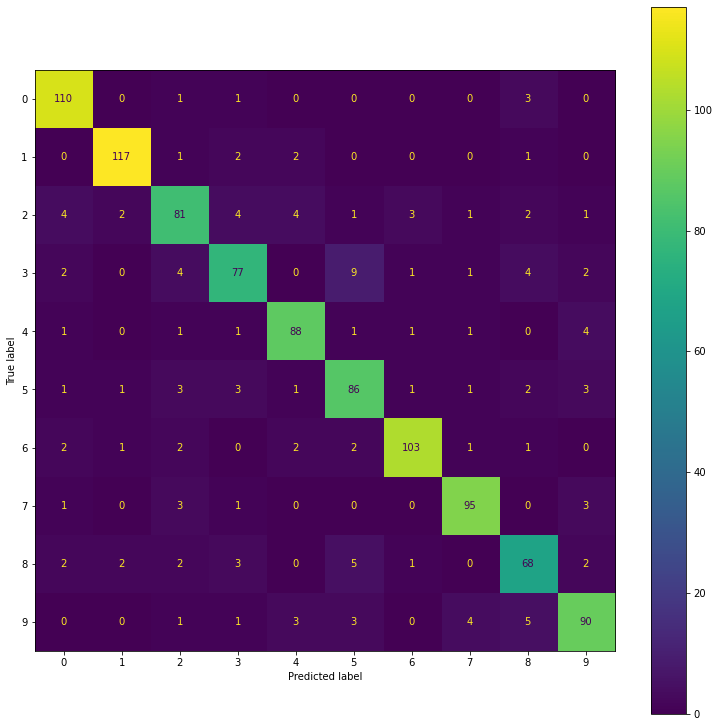

In [28]:
lr = LogisticRegression()
build_and_eval_model(lr, X, y)

Running report for model RandomForestClassifier()


Accuracy 0.919048
              precision    recall  f1-score   support

           0       0.93      0.98      0.96       115
           1       0.97      0.97      0.97       123
           2       0.89      0.88      0.89       103
           3       0.89      0.86      0.87       100
           4       0.92      0.92      0.92        98
           5       0.91      0.85      0.88       102
           6       0.97      0.96      0.97       114
           7       0.94      0.89      0.92       103
           8       0.91      0.91      0.91        85
           9       0.85      0.93      0.89       107

    accuracy                           0.92      1050
   macro avg       0.92      0.92      0.92      1050
weighted avg       0.92      0.92      0.92      1050



RandomForestClassifier()

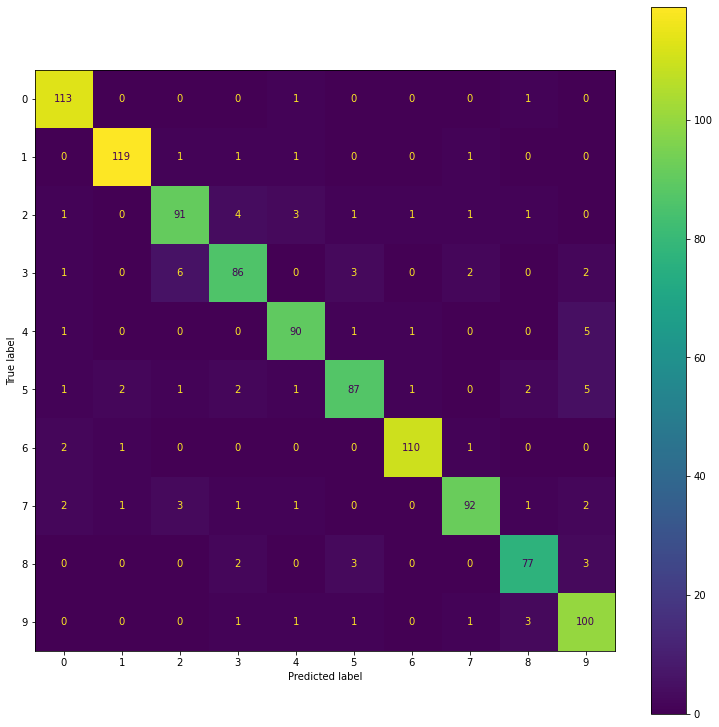

In [29]:
rf = RandomForestClassifier()

build_and_eval_model(rf, X, y)

Running report for model LinearSVC()


Accuracy 0.812381
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       115
           1       0.93      0.94      0.94       123
           2       0.75      0.71      0.73       103
           3       0.75      0.77      0.76       100
           4       0.88      0.77      0.82        98
           5       0.82      0.82      0.82       102
           6       0.89      0.89      0.89       114
           7       0.85      0.87      0.86       103
           8       0.70      0.56      0.62        85
           9       0.67      0.75      0.70       107

    accuracy                           0.81      1050
   macro avg       0.81      0.80      0.80      1050
weighted avg       0.81      0.81      0.81      1050



/Users/zacharydesario/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LinearSVC()

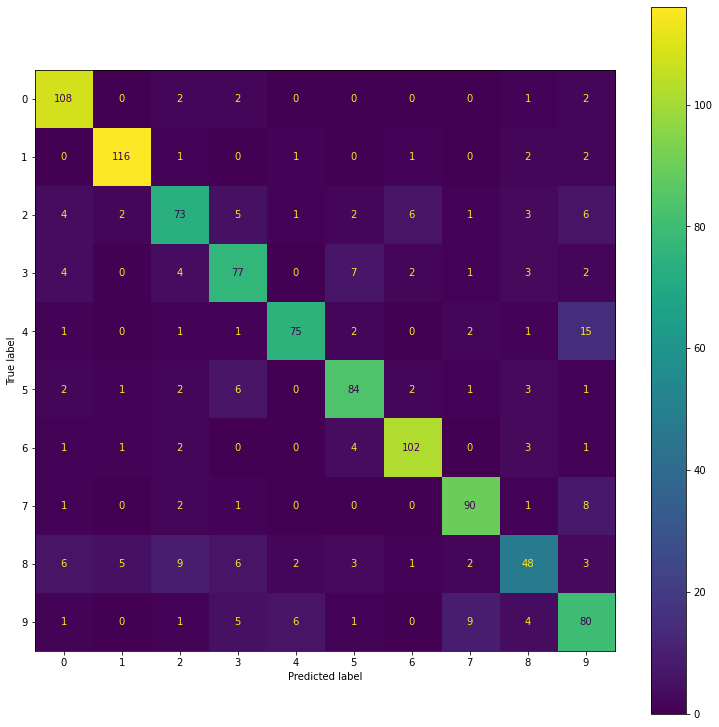

In [30]:
lsvc = svm.LinearSVC()

build_and_eval_model(lsvc, X, y)

Running report for model MultinomialNB()


Accuracy 0.823810
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       115
           1       0.93      0.91      0.92       123
           2       0.86      0.83      0.84       103
           3       0.86      0.83      0.85       100
           4       0.72      0.66      0.69        98
           5       0.90      0.68      0.77       102
           6       0.85      0.91      0.88       114
           7       0.94      0.85      0.89       103
           8       0.62      0.80      0.70        85
           9       0.70      0.81      0.75       107

    accuracy                           0.82      1050
   macro avg       0.83      0.82      0.82      1050
weighted avg       0.83      0.82      0.82      1050



MultinomialNB()

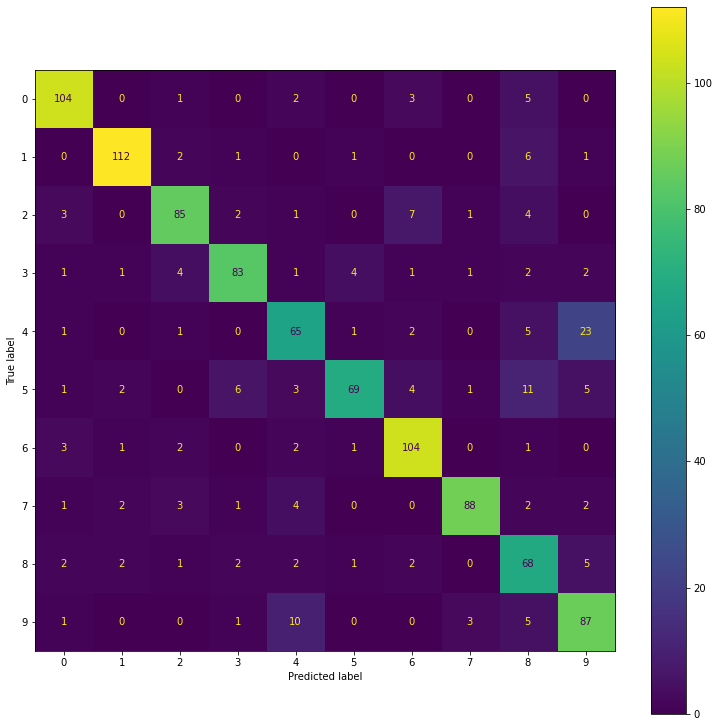

In [31]:
from sklearn.naive_bayes import MultinomialNB
mnb = MultinomialNB()
build_and_eval_model(mnb, X, y)

Running report for model SVC()


Accuracy 0.939048
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       115
           1       0.98      0.97      0.97       123
           2       0.91      0.90      0.91       103
           3       0.93      0.88      0.90       100
           4       0.92      0.93      0.92        98
           5       0.92      0.96      0.94       102
           6       0.94      0.98      0.96       114
           7       0.97      0.93      0.95       103
           8       0.95      0.91      0.93        85
           9       0.92      0.93      0.92       107

    accuracy                           0.94      1050
   macro avg       0.94      0.94      0.94      1050
weighted avg       0.94      0.94      0.94      1050



SVC()

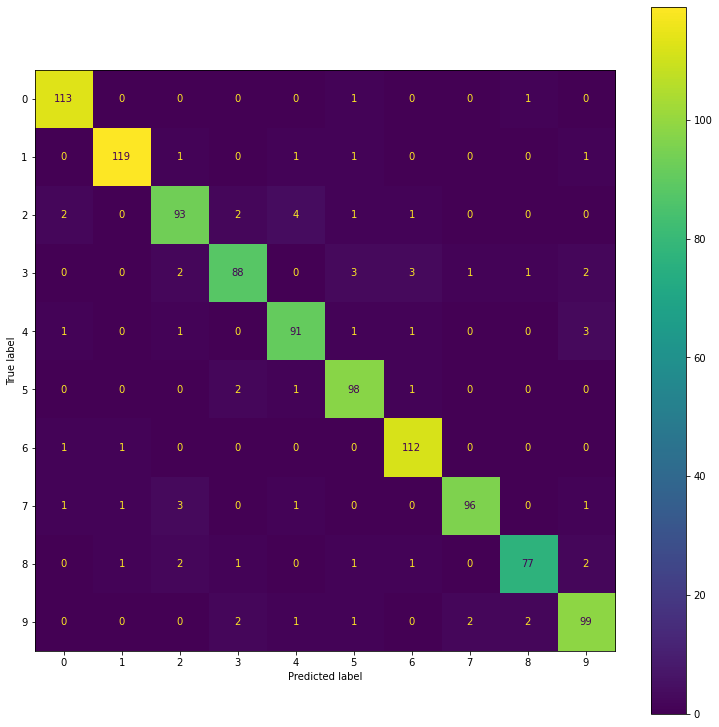

In [29]:
model = svm.SVC()
build_and_eval_model(model, X, y)